In [1]:
#ÂõæÁâáËØÜÂà´ÔºöÊ§çÁâ©ÁóÖÂÆ≥ËØÜÂà´
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
import shutil, random
from pathlib import Path
import matplotlib.pyplot as plt
import torch
from fastai.vision.all import (
    DataBlock, ImageBlock, CategoryBlock, get_image_files,
    GrandparentSplitter, parent_label, Resize, aug_transforms,
    vision_learner, accuracy, ClassificationInterpretation, resnet34)
from fastai.torch_core import default_device
from fastai.callback.tracker import EarlyStoppingCallback, SaveModelCallback
import time


In [2]:
# device selection
def set_device():
    if torch.cuda.is_available(): default_device('cuda'); print('‰ΩøÁî®CUDAÂä†ÈÄü')
    elif torch.backends.mps.is_available(): default_device('mps'); print('‰ΩøÁî®MPSÂä†ÈÄü')
    else: default_device('cpu'); print('‰ΩøÁî®CPU')
set_device()

‰ΩøÁî®CPU


In [3]:
def split_dataset(src_base_path, dest_base_path, categories, train_ratio, valid_ratio, test_ratio):
    assert train_ratio + valid_ratio + test_ratio == 1, "Ratios should add up to 1."
    
    # Remove existing destination directory if it exists
    if dest_base_path.exists():
        shutil.rmtree(dest_base_path)
    
    # Create destination directories
    for phase in ['train', 'valid', 'test']:
        for cat in categories:
            os.makedirs(dest_base_path/phase/cat, exist_ok=True)
    
    # Split and copy files for each category
    for cat in categories:
        files = list((Path(src_base_path)/cat).glob('*.*'))
        random.shuffle(files)
        n = len(files)
        
        # Calculate split indices
        train_end = int(n * train_ratio)
        valid_end = train_end + int(n * valid_ratio)
        
        # Split files into three sets
        train_files = files[:train_end]
        valid_files = files[train_end:valid_end]
        test_files = files[valid_end:]
        
        # Copy files to respective directories
        for f in train_files:
            shutil.copy(f, dest_base_path/'train'/cat/f.name)
        for f in valid_files:
            shutil.copy(f, dest_base_path/'valid'/cat/f.name)
        for f in test_files:
            shutil.copy(f, dest_base_path/'test'/cat/f.name)
        
        # Print statistics for each category
        print(f"\nCategory: {cat}")
        print(f"Total files: {n}")
        print(f"Train set: {len(train_files)} files")
        print(f"Valid set: {len(valid_files)} files")
        print(f"Test set: {len(test_files)} files")
        
        # Verify the splits
        assert len(train_files) + len(valid_files) + len(test_files) == n, \
            f"Split verification failed for category {cat}"
    
    # Print overall statistics
    print("\nOverall Dataset Statistics:")
    for phase in ['train', 'valid', 'test']:
        total_files = sum(len(list((dest_base_path/phase/cat).glob('*.*'))) 
                        for cat in categories)
        print(f"{phase.capitalize()} set: {total_files} files")

In [4]:
src_base_path = Path('image')
dest_base_path = Path('images')
cats = ['ÈªëÊñëÁóÖ', 'ÈîàÊñëÁóÖ','ÁôΩÁ≤âÁóÖ','ÁÇ≠ÁñΩÁóÖ','Èó∑Ê†π']
split_dataset(src_base_path, dest_base_path, cats, 0.6, 0.2, 0.2)


Category: ÈªëÊñëÁóÖ
Total files: 84
Train set: 50 files
Valid set: 16 files
Test set: 18 files

Category: ÈîàÊñëÁóÖ
Total files: 81
Train set: 48 files
Valid set: 16 files
Test set: 17 files

Category: ÁôΩÁ≤âÁóÖ
Total files: 72
Train set: 43 files
Valid set: 14 files
Test set: 15 files

Category: ÁÇ≠ÁñΩÁóÖ
Total files: 111
Train set: 66 files
Valid set: 22 files
Test set: 23 files

Category: Èó∑Ê†π
Total files: 90
Train set: 54 files
Valid set: 18 files
Test set: 18 files

Overall Dataset Statistics:
Train set: 261 files
Valid set: 86 files
Test set: 91 files


In [5]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='train', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)
)
dls = dblock.dataloaders(dest_base_path, bs=64,seed = 42)



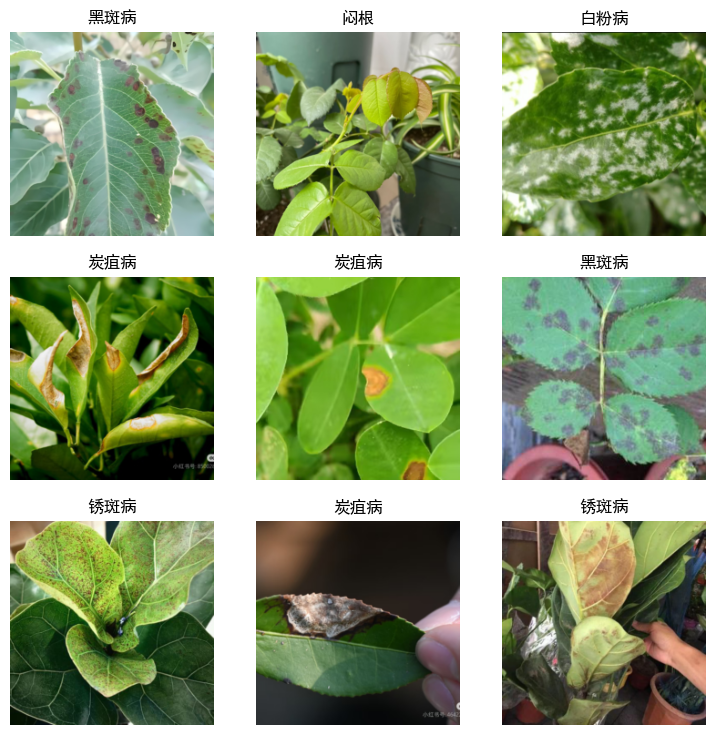

In [6]:
plt.rcParams['font.sans-serif'] = ['SimHei']
# plt.rcParams['font.sans-serif'] = ['Microsoft YaHei'] # ÊåáÂÆöÈªòËÆ§Â≠ó‰ΩìÔºöËß£ÂÜ≥plot‰∏çËÉΩÊòæÁ§∫‰∏≠ÊñáÈóÆÈ¢ò
plt.rcParams['axes.unicode_minus'] = False # Ëß£ÂÜ≥‰øùÂ≠òÂõæÂÉèÊòØË¥üÂè∑'-'ÊòæÁ§∫‰∏∫ÊñπÂùóÁöÑÈóÆÈ¢ò
dls.show_batch()

In [7]:
early_stop_cb = EarlyStoppingCallback(monitor='valid_loss', patience=3)
save_model_cb = SaveModelCallback(monitor='valid_loss')

learn = vision_learner(dls, resnet34, metrics=accuracy, cbs=[early_stop_cb, save_model_cb])
# learn = vision_learner(dls, resnet34, metrics=accuracy, cbs=[early_stop_cb, save_model_cb])

In [8]:
learn.fine_tune(100)

Better model found at epoch 0 with valid_loss value: 2.1682746410369873.


Better model found at epoch 0 with valid_loss value: 1.5347870588302612.
Better model found at epoch 1 with valid_loss value: 1.1295204162597656.
Better model found at epoch 2 with valid_loss value: 0.926498293876648.
Better model found at epoch 3 with valid_loss value: 0.8213214874267578.
Better model found at epoch 4 with valid_loss value: 0.7571465969085693.
Better model found at epoch 5 with valid_loss value: 0.7082279324531555.
Better model found at epoch 6 with valid_loss value: 0.66966313123703.
Better model found at epoch 7 with valid_loss value: 0.6438074707984924.
Better model found at epoch 8 with valid_loss value: 0.6166880130767822.
Better model found at epoch 9 with valid_loss value: 0.6065660119056702.
Better model found at epoch 10 with valid_loss value: 0.5972961783409119.
Better model found at epoch 11 with valid_loss value: 0.5891832709312439.
Better model found at epoch 13 with valid_loss value: 0.5841173529624939.
Better model found at epoch 14 with valid_loss valu

In [9]:
test_dl = dls.test_dl(get_image_files(dest_base_path/'test'), with_labels=True)
loss, acc = learn.validate(dl=test_dl)

Better model found at epoch 0 with valid_loss value: 0.7058823704719543.


In [10]:
loss

0.9750913977622986

In [11]:
acc

0.7058823704719543

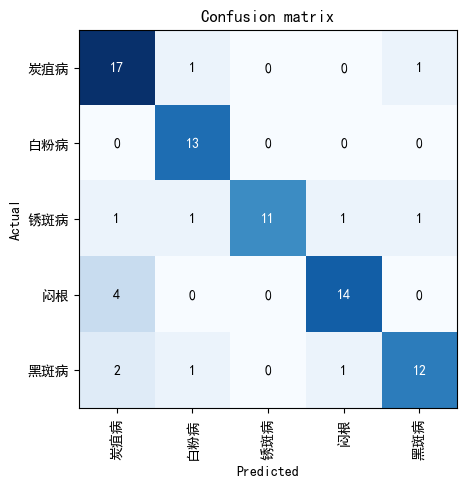

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [13]:
interp.print_classification_report()

              precision    recall  f1-score   support

         ÁÇ≠ÁñΩÁóÖ       0.71      0.89      0.79        19
         ÁôΩÁ≤âÁóÖ       0.81      1.00      0.90        13
         ÈîàÊñëÁóÖ       1.00      0.73      0.85        15
          Èó∑Ê†π       0.88      0.78      0.82        18
         ÈªëÊñëÁóÖ       0.86      0.75      0.80        16

    accuracy                           0.83        81
   macro avg       0.85      0.83      0.83        81
weighted avg       0.85      0.83      0.83        81



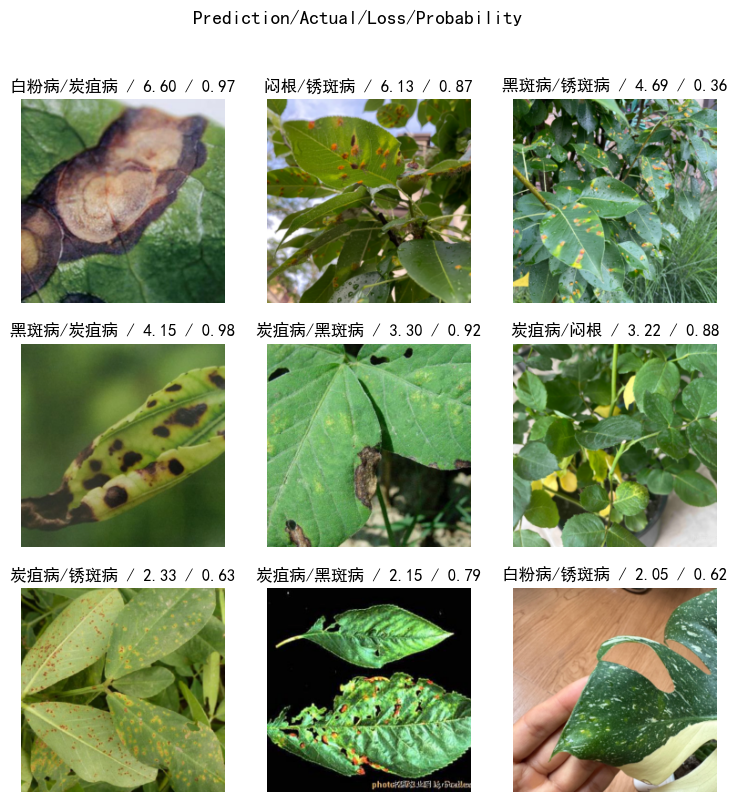

In [14]:
interp.plot_top_losses(9)

In [15]:
learn.export('Ê§çÁâ©ÁóÖÂÆ≥ËØÜÂà´.pkl')

In [16]:
from fastai.vision.all import * # ÂØºÂÖ• fastai ËßÜËßâÂ∫ìÁöÑÊâÄÊúâÊ®°Âùó
from torchcam.methods import CAM, SmoothGradCAMpp # ‰ªé torchcam Â∫ìÂØºÂÖ• CAM Âíå SmoothGradCAMpp ÊñπÊ≥ï
from torchvision.transforms import Compose, Resize, ToTensor, Normalize # ‰ªé torchvision ÂØºÂÖ•ÂõæÂÉèÂèòÊç¢Áõ∏ÂÖ≥Á±ª
from torchvision.transforms.functional import to_pil_image # ‰ªé torchvision.transforms.functional ÂØºÂÖ•Â∞Ü Tensor ËΩ¨Êç¢‰∏∫ PIL ÂõæÂÉèÁöÑÂáΩÊï∞
from PIL import Image # ÂØºÂÖ• PIL Â∫ìÁî®‰∫éÂõæÂÉèÂ§ÑÁêÜ
from torchcam.utils import overlay_mask # ‰ªé torchcam Â∫ìÂØºÂÖ•Áî®‰∫éÂè†Âä†Êé©Á†ÅÁöÑÂ∑•ÂÖ∑ÂáΩÊï∞

In [17]:
def visualize_cam(learner, image_path, cam_class=SmoothGradCAMpp):
    """
    ÂèØËßÜÂåñÊåáÂÆöÂõæÂÉèÁöÑÁ±ªÊøÄÊ¥ªÂõæ (CAM)„ÄÇ

    ÂèÇÊï∞:
        learner: fastai ÁöÑ Learner ÂØπË±°ÔºåÂåÖÂê´‰∫ÜËÆ≠ÁªÉÂ•ΩÁöÑÊ®°Âûã„ÄÇ
        image_path (str): ÈúÄË¶ÅÂèØËßÜÂåñÁöÑÂõæÂÉèÊñá‰ª∂Ë∑ØÂæÑ„ÄÇ
        cam_class (type): Áî®‰∫éÁîüÊàê CAM ÁöÑÁ±ªÔºåÈªòËÆ§‰∏∫ SmoothGradCAMpp„ÄÇ
    """
    # Âä†ËΩΩÂõæÂÉèÊñá‰ª∂ÔºåÂπ∂Á°Æ‰øùÂõæÂÉèÊòØ RGB Ê†ºÂºè
    img = Image.open(image_path).convert('RGB')

    # ÂÆö‰πâ‰∏ÄÁ≥ªÂàóÂõæÂÉèÈ¢ÑÂ§ÑÁêÜÊ≠•È™§
    preprocess = Compose([
        Resize(224), # Â∞ÜÂõæÂÉèÂ§ßÂ∞èË∞ÉÊï¥‰∏∫ 224x224 ÂÉèÁ¥†
        ToTensor(), # Â∞Ü PIL ÂõæÂÉèËΩ¨Êç¢‰∏∫ PyTorch Tensor
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # ‰ΩøÁî® ImageNet ÁöÑÂùáÂÄºÂíåÊ†áÂáÜÂ∑ÆÂØπÂõæÂÉèËøõË°åÊ†áÂáÜÂåñ
    ])

    # Â∫îÁî®È¢ÑÂ§ÑÁêÜÊ≠•È™§Âà∞Âä†ËΩΩÁöÑÂõæÂÉè‰∏ä
    input_tensor = preprocess(img)
    # Âú® Tensor ÁöÑÁ¨¨ 0 Áª¥Â¢ûÂä†‰∏Ä‰∏™Áª¥Â∫¶Ôºå‰ª•Á¨¶ÂêàÊ®°ÂûãËæìÂÖ•ÁöÑ batch Ë¶ÅÊ±Ç (batch_size=1)
    input_tensor = input_tensor.unsqueeze(0)

    # ‰ªé Learner ÂØπË±°‰∏≠Ëé∑ÂèñÂ∫ïÂ±ÇÁöÑ PyTorch Ê®°ÂûãÔºåÂπ∂ËÆæÁΩÆ‰∏∫ËØÑ‰º∞Ê®°Âºè (eval mode)
    # ËØÑ‰º∞Ê®°Âºè‰ºöÂÖ≥Èó≠ dropout Âíå batch normalization ÁöÑÊõ¥Êñ∞
    model = learner.model.eval()

    # ‰ΩøÁî®ÊåáÂÆöÁöÑ CAM Á±ªÂàùÂßãÂåñ CAM ÊèêÂèñÂô®ÔºåÂπ∂Â∞ÜÂÖ∂‰Ωú‰∏∫‰∏ä‰∏ãÊñáÁÆ°ÁêÜÂô®‰ΩøÁî®
    # ËøôÊ†∑ÂèØ‰ª•Á°Æ‰øùËµÑÊ∫êË¢´Ê≠£Á°ÆÁÆ°ÁêÜ
    with cam_class(model) as cam_extractor:
        # Â∞ÜÈ¢ÑÂ§ÑÁêÜÂêéÁöÑÂõæÂÉè Tensor ËæìÂÖ•Ê®°ÂûãÔºåËé∑ÂèñÊ®°ÂûãÁöÑËæìÂá∫ÂàÜÊï∞ (logits)
        scores = model(input_tensor)

        # ‰ªéÊ®°ÂûãËæìÂá∫‰∏≠ÁßªÈô§ batch Áª¥Â∫¶ÔºåÁÑ∂ÂêéÊâæÂà∞ÂàÜÊï∞ÊúÄÈ´òÁöÑÈÇ£‰∏™Á±ªÂà´ÁöÑÁ¥¢Âºï
        pred_class_idx = scores.squeeze(0).argmax().item()

        # ‰ΩøÁî® CAM ÊèêÂèñÂô®ËÆ°ÁÆóÊåáÂÆöÈ¢ÑÊµãÁ±ªÂà´ÁöÑÊøÄÊ¥ªÂõæ
        # cam_extractor ËøîÂõûÁöÑÊòØ‰∏Ä‰∏™ÂåÖÂê´ÊøÄÊ¥ªÂõæÁöÑÂàóË°®ÔºåÊàë‰ª¨ÂèñÁ¨¨‰∏Ä‰∏™ÂÖÉÁ¥†
        activation_map = cam_extractor(pred_class_idx, scores)[0]

    # Â∞ÜËÆ°ÁÆóÂæóÂà∞ÁöÑÊøÄÊ¥ªÂõæ (ÈÄöÂ∏∏ÊòØÂçïÈÄöÈÅìÁöÑÊµÆÁÇπÊï∞ Tensor) ËΩ¨Êç¢Âõû PIL ÂõæÂÉèÊ†ºÂºè
    # mode='F' Ë°®Á§∫ËæìÂÖ•ÊòØ 32 ‰ΩçÊµÆÁÇπÊï∞
    # .cpu() ÊòØÂõ†‰∏∫ to_pil_image ÈúÄË¶Å CPU Tensor
    heatmap_pil = to_pil_image(activation_map.cpu(), mode='F')

    # Â∞ÜÁîüÊàêÁöÑÊøÄÊ¥ªÂõæ (ÁÉ≠ÂäõÂõæ) Âè†Âä†Âà∞ÂéüÂßãÂõæÂÉè‰∏ä
    # alpha ÂèÇÊï∞ÊéßÂà∂ÁÉ≠ÂäõÂõæÁöÑÈÄèÊòéÂ∫¶
    overlayed_img = overlay_mask(img, heatmap_pil, alpha=0.5)

    # ÂàõÂª∫‰∏Ä‰∏™Êñ∞ÁöÑ matplotlib ÂõæÂΩ¢Á™óÂè£Êù•ÊòæÁ§∫ÁªìÊûú
    plt.figure(figsize=(6, 6)) # ÂèØ‰ª•Ë∞ÉÊï¥ÂõæÂΩ¢Â§ßÂ∞è
    # ÊòæÁ§∫Âè†Âä†‰∫ÜÁÉ≠ÂäõÂõæÁöÑÂõæÂÉè
    plt.imshow(overlayed_img)
    # ËÆæÁΩÆÂõæÂÉèÊ†áÈ¢òÔºåÂåÖÂê´ÊâÄ‰ΩøÁî®ÁöÑ CAM ÊñπÊ≥ïÁöÑÂêçÁß∞
    plt.title(f"{cam_class.__name__} Âè†Âä†ÊïàÊûú")
    # ÂÖ≥Èó≠ÂùêÊ†áËΩ¥ÊòæÁ§∫
    plt.axis('off')
    # ÊòæÁ§∫ÂõæÂΩ¢
    plt.show()
    # Èò≤Ê≤ªÂª∫ËÆÆÈÄªËæë
    try:
        treatment_df = pd.read_excel('Èò≤Ê≤ª.xlsx')
        pred_class = learner.predict(image_path)[0]
        print(f"\nüîç ËØÜÂà´ÁªìÊûú: {pred_class}")
        
        if not treatment_df.empty:
            match = treatment_df[treatment_df['ÁñæÁóÖ'] == pred_class]
            if not match.empty:
                treatment = match.iloc[0]
                print(f"üìù ÁóáÁä∂ÊèèËø∞: {treatment['ÁóáÁä∂']}")
                print("üíä Êé®ËçêÈò≤Ê≤ªÊñπÊ°à:")
                for i in range(1, 9):
                    remedy = treatment.get(f'Èò≤Ê≤ª{i}')
                    if pd.notna(remedy) and str(remedy).strip():
                        print(f"{i}. {remedy}")
            else:
                print("‚ö†Ô∏è Êú™ÊâæÂà∞ËØ•ÁóÖÂÆ≥ÁöÑÈò≤Ê≤ªÊñπÊ°à")
    except Exception as e:
        print(f"‚ö†Ô∏è Êï∞ÊçÆÂä†ËΩΩÂ§±Ë¥•: {str(e)}")


In [18]:
def visualize_random_images(learner, baifenbing_dir='images/test/ÁôΩÁ≤âÁóÖ', heibanbing_dir='images/test/ÈªëÊñëÁóÖ',mengen_dir='images/test/Èó∑Ê†π',tanjubing_dir='images/test/ÁÇ≠ÁñΩÁóÖ',xiubanbing_dir='images/test/ÈîàÊñëÁóÖ'):
    """
    ÈöèÊú∫ÈÄâÊã©Âπ∂ÂèØËßÜÂåñÁõ∏ÂÖ≥Ê§çÁâ©ÂõæÁâáÁöÑ CAM ÊïàÊûú„ÄÇ
    
    ÂèÇÊï∞:
        learner: fastai ÁöÑ Learner ÂØπË±°
        walle_dir (str): WALL-E ÂõæÁâáÁõÆÂΩïË∑ØÂæÑ
        doraemon_dir (str): ÂìÜÂï¶AÊ¢¶ÂõæÁâáÁõÆÂΩïË∑ØÂæÑ
    """
    # Ëé∑ÂèñÊñá‰ª∂Â§π‰∏≠ÁöÑÂõæÁâáÊñá‰ª∂
    baifenbing_images = os.listdir(baifenbing_dir)
    heibanbing_images = os.listdir(heibanbing_dir)
    mengen_images = os.listdir(mengen_dir)
    tanjubing_images = os.listdir(tanjubing_dir)
    xiubanbing_images = os.listdir(xiubanbing_dir)

       # ÈöèÊú∫ÈÄâÊã©ÂêÑÁóÖÂÆ≥Ê†∑Êú¨
    baifenbing_image = random.choice(baifenbing_images)
    heibanbing_image = random.choice(heibanbing_images)
    mengen_image = random.choice(mengen_images)
    tanjubing_image = random.choice(tanjubing_images)
    xiubanbing_image = random.choice(xiubanbing_images)

    # ÊûÑÂª∫ÂÆåÊï¥Ë∑ØÂæÑ
    baifenbing_path = os.path.join(baifenbing_dir, baifenbing_image)
    heibanbing_path = os.path.join(heibanbing_dir, heibanbing_image)
    mengen_path = os.path.join(mengen_dir, mengen_image)
    tanjubing_path = os.path.join(tanjubing_dir, tanjubing_image)
    xiubanbing_path = os.path.join(xiubanbing_dir, xiubanbing_image)

    # ÊâìÂç∞ÈÄâÊã©ÁöÑÂõæÁâáË∑ØÂæÑ
    print(f"ÈöèÊú∫ÈÄâÊã©ÁöÑÁôΩÁ≤âÁóÖÊ†∑Êú¨: {baifenbing_path}")
    print(f"ÈöèÊú∫ÈÄâÊã©ÁöÑÈªëÊñëÁóÖÊ†∑Êú¨: {heibanbing_path}") 
    print(f"ÈöèÊú∫ÈÄâÊã©ÁöÑÈó∑Ê†πÊ†∑Êú¨: {mengen_path}")
    print(f"ÈöèÊú∫ÈÄâÊã©ÁöÑÁÇ≠ÁñΩÁóÖÊ†∑Êú¨: {tanjubing_path}")
    print(f"ÈöèÊú∫ÈÄâÊã©ÁöÑÈîàÊñëÁóÖÊ†∑Êú¨: {xiubanbing_path}")

    # ÂèØËßÜÂåñÊâÄÊúâÁóÖÂÆ≥ÁöÑCAMÊïàÊûú
    visualize_cam(learn, baifenbing_path)
    visualize_cam(learn, heibanbing_path)
    visualize_cam(learn, mengen_path)
    visualize_cam(learn, tanjubing_path)
    visualize_cam(learn, xiubanbing_path)



In [19]:
learn = load_learner('Ê§çÁâ©ÁóÖÂÆ≥ËØÜÂà´.pkl')

d:\CBY\CBYANACONDA\envs\datascience\Lib\site-packages\fastai\learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


ÈöèÊú∫ÈÄâÊã©ÁöÑÁôΩÁ≤âÁóÖÊ†∑Êú¨: images/test/ÁôΩÁ≤âÁóÖ\64.webp
ÈöèÊú∫ÈÄâÊã©ÁöÑÈªëÊñëÁóÖÊ†∑Êú¨: images/test/ÈªëÊñëÁóÖ\59.jpeg
ÈöèÊú∫ÈÄâÊã©ÁöÑÈó∑Ê†πÊ†∑Êú¨: images/test/Èó∑Ê†π\25.jpg
ÈöèÊú∫ÈÄâÊã©ÁöÑÁÇ≠ÁñΩÁóÖÊ†∑Êú¨: images/test/ÁÇ≠ÁñΩÁóÖ\81.jpg
ÈöèÊú∫ÈÄâÊã©ÁöÑÈîàÊñëÁóÖÊ†∑Êú¨: images/test/ÈîàÊñëÁóÖ\68.jpg


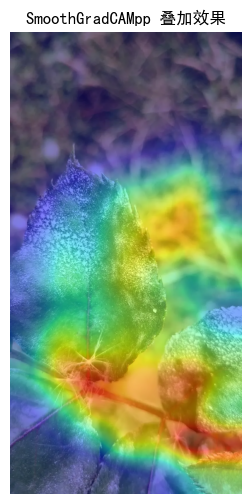


üîç ËØÜÂà´ÁªìÊûú: ÁôΩÁ≤âÁóÖ
üìù ÁóáÁä∂ÊèèËø∞: Âè∂Áâá„ÄÅÂ´©Ëåé„ÄÅËä±ËïæË°®Èù¢Ë¶ÜÁõñ‰∏ÄÂ±ÇÁôΩËâ≤Á≤âÊú´Áä∂ÈúâÂ±ÇÔºàËèå‰∏ùÂíåÂ≠¢Â≠êÔºâÔºåÂêéÊúüÁóÖÊñëÂèò‰∏∫ÁÅ∞Ëâ≤ÔºåÂè∂ÁâáÊâ≠Êõ≤„ÄÅËêéÁº©ÔºåÊ§çÊ†™ÁîüÈïøÂèóÈòª
üíä Êé®ËçêÈò≤Ê≤ªÊñπÊ°à:
1. Èõ®Â≠£ÊàñÈ´òÊ∏©È´òÊπøÂ≠£ËäÇÂâçÔºåÂñ∑ÊñΩÊ≥¢Â∞îÂ§öÊ∂≤Ôºà1:1:100ÔºâÊàñÁü≥Á°´ÂêàÂâÇÔºà0.3-0.5 Ê≥¢ÁæéÂ∫¶ÔºâÔºåÂΩ¢Êàê‰øùÊä§Â±èÈöú
2. Áî®ËΩØÂ∏ÉËò∏ÂèñÁ®ÄÈáäÁöÑÈÖíÁ≤æÔºà50%ÊµìÂ∫¶ÔºâÊàñÂ∞èËãèÊâìÊ∫∂Ê∂≤Ôºà5gÂ∞èËãèÊâì+1LÊ∞¥ÔºâËΩªËΩªÊì¶Êã≠ÁóÖÂè∂ÔºåÁ†¥ÂùèËèå‰∏ùÁªìÊûÑ
3. ÊàäÂîëÈÜáÔºà25%Ê∞¥‰π≥ÂâÇ2000ÂÄçÊ∂≤ÔºâÊàñÂê°ÂîëÈÜöËèåÈÖØÔºà25%ÊÇ¨ÊµÆÂâÇ1500ÂÄçÊ∂≤ÔºâÔºåÂÜÖÂê∏ÊÄßÂº∫ÔºåÂèØÊùÄÁÅ≠Ê∑±Â±ÇÁóÖËèå


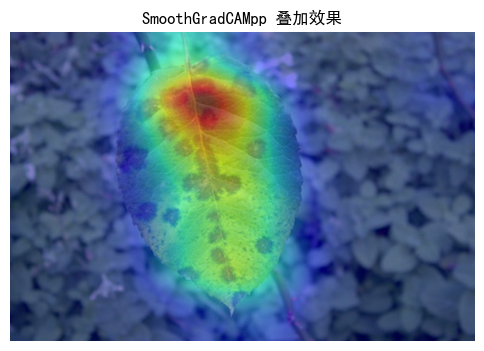


üîç ËØÜÂà´ÁªìÊûú: ÈªëÊñëÁóÖ
üìù ÁóáÁä∂ÊèèËø∞: Âè∂ÁâáÂá∫Áé∞ÈªëËâ≤ÂúÜÂΩ¢ Ôºå‰∏çËßÑÂàôÁóÖÊñëÔºåËæπÁºòÊ≥õÈªÑÔºå‰∏•ÈáçÊó∂ËêΩÂè∂„ÄÅÊ§çÊ†™ÊûØËêé
üíä Êé®ËçêÈò≤Ê≤ªÊñπÊ°à:
1. Â∞ÜÊ§çÁâ©ÊîæÁΩÆÂú®ÈÄöÈ£éËâØÂ•Ω„ÄÅÂÖâÁÖßÂÖÖË∂≥Â§ÑÔºåÈôç‰ΩéÁ©∫Ê∞îÊπøÂ∫¶ÔºåÂáèÂ∞ëÁóÖËèåÊªãÁîü
2. ÈÅøÂÖçÂÇçÊôöÊµáÊ∞¥ÊàñÁõ¥Êé•Ê∑ãÊµáÂè∂ÁâáÔºåÂª∫ËÆÆÊ≤øÁõÜËæπÊµáÁÅåÔºåÂáèÂ∞ëÂè∂Èù¢ÊπøÂ∫¶
3. ‰ΩøÁî®ÁñèÊùæÈÄèÊ∞îÁöÑËÖêÊÆñÂúüÔºåÂÆöÊúüÊñΩÁî®ÊúâÊú∫ËÇ•ÊàñÂùáË°°Â§çÂêàËÇ•ÔºåÂ¢ûÂº∫Ê§çÊ†™ÊäóÁóÖÂäõ
4. ÂÆöÊúüÂØπËä±ÁõÜ„ÄÅÂ∑•ÂÖ∑ÔºåÁî®1% Á°´ÈÖ∏ÈìúÊ∫∂Ê∂≤ÊàñÂ§öËèåÁÅµÊ∫∂Ê∂≤Ê∂àÊØíÔºåÈÅøÂÖç‰∫§ÂèâÊÑüÊüì
5. ËêΩÂè∂Ê§çÁâ©ÂÖ•ÂÜ¨ÂâçÊ∏ÖÁêÜÊûØÊûùËêΩÂè∂ÔºåÂñ∑ÊñΩÁü≥Á°´ÂêàÂâÇ3-5Ê≥¢ÁæéÂ∫¶ÔºåÊùÄÁÅ≠Ë∂äÂÜ¨ÁóÖËèå
6. Âçï‰∏ÄËçØÂâÇÊòìÂØºËá¥ÁóÖËèå‰∫ßÁîüÊäóËçØÊÄßÔºåÂª∫ËÆÆ‰øùÊä§ÊÄßÊùÄËèåÂâÇ‰ª£Ê£ÆÈî∞Èîå‰∏éÊ≤ªÁñóÊÄßÊùÄËèåÂâÇÊàäÂîëÈÜá‰∫§Êõø‰ΩøÁî®
7. Áî®ÊÅ∂ÈúâÁÅµ300ÂÄçÊ∂≤ÊàñÁî≤Âü∫ÊâòÂ∏ÉÊ¥•500ÂÄçÊ∂≤ÊµáÁÅåÊ†πÈÉ®ÔºåÊäëÂà∂ÂúüÂ£§‰∏≠ÁöÑÁóÖËèå
8. ‰ΩøÁî®ËãØÈÜöÁî≤ÁéØÂîë10%Ê∞¥ÂàÜÊï£Á≤íÂâÇ1500ÂÄçÊ∂≤ÔºåÊØè5-7Â§©1Ê¨°ÔºåËøûÁª≠3Ê¨°


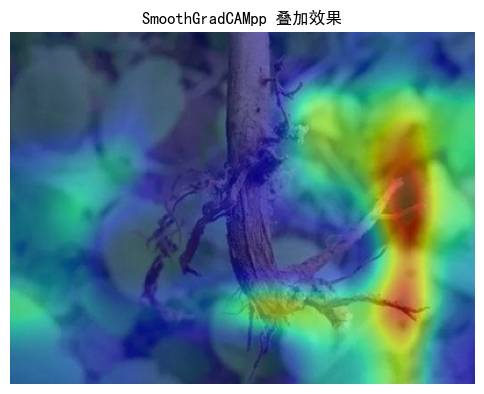


üîç ËØÜÂà´ÁªìÊûú: Èó∑Ê†π
üìù ÁóáÁä∂ÊèèËø∞: Ê†πÁ≥ªÁº∫Ê∞ßËÖêÁÉÇÔºåÂè∂ÁâáËêéËî´„ÄÅÂèëÈªÑ„ÄÅÊó†ÂÖâÊ≥ΩÔºåÊñ∞Âè∂Âç∑Êõ≤Ôºå‰∏•ÈáçÊó∂Êï¥Ê†™ÊûØËêéÔºåÊãîËµ∑Ê§çÊ†™ÂèØËßÅÊ†πÁ≥ªÂèòÈªë„ÄÅËÖêÁÉÇÔºåÊúâÈÖ∏Ëá≠Âë≥
üíä Êé®ËçêÈò≤Ê≤ªÊñπÊ°à:
1. ÈÄâÁî®ÁñèÊùæÈÄèÊ∞îÁöÑÂúüÂ£§ÔºåÈÄöÁî®ÈÖçÊñπÔºöËÖêÂè∂Âúü3‰ªΩ+ÁèçÁè†Â≤©2‰ªΩ+Á≤óÊ≤ô2‰ªΩ+ÊúâÊú∫ËÇ•1‰ªΩ
2. Ëä±ÁõÜÂ∫ïÈÉ®Âû´Èô∂Á≤í„ÄÅÁ¢éÁì¶ÁâáÊàñÊ∏óÊ∞¥Â±ÇÔºåÈÅøÂÖçÂ∫ïÂ≠îÂ†µÂ°û
3. ÊµáÊ∞¥ÂâçÁî®ÊâãÊåáÊèíÂÖ•Âúü‰∏≠ 2-3cmÔºåÊÑüËßâÂπ≤Áá•ÂÜçÊµáÈÄèÔºåÈÅøÂÖçÈ¢ëÁπÅÊµáÊ∞¥
4. ÂÜ¨Â≠£ÊàñÈò¥Èõ®Â§©ÂáèÂ∞ëÊµáÊ∞¥È¢ëÁéáÔºåÊ∞îÊ∏©‰ΩéÊó∂Ê†πÁ≥ªÂê∏Ê∞¥ÊÖ¢ÔºåÊòìÁßØÊ∞¥Èó∑Ê†π
5. Èú≤ÂÖªÊ§çÁâ©Èõ®Â≠£ÂèäÊó∂Êê¨ÂÖ•ÂÆ§ÂÜÖÔºåÈÅøÂÖçÁõÜÂúüÈïøÊúüÊµ∏Ê≥°
6. Ê†πÁ≥ªÊµ∏Ê≥°ÁîüÊ†πÁ≤âÊ∫∂Ê∂≤Ôºà1000ÂÄçÊ∂≤Ôºâ15ÂàÜÈíüÔºåÊôæÂπ≤2-3Â∞èÊó∂ÂêéÊç¢Êñ∞Âúü‰∏äÁõÜ


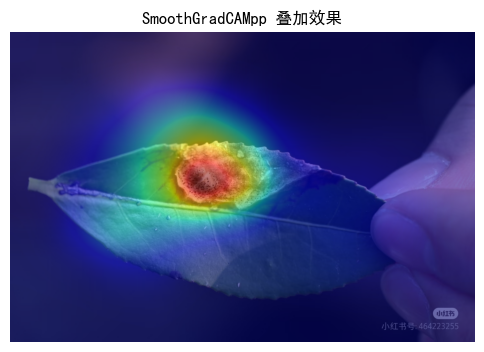


üîç ËØÜÂà´ÁªìÊûú: ÁÇ≠ÁñΩÁóÖ
üìù ÁóáÁä∂ÊèèËø∞: Âè∂ÁâáÂá∫Áé∞ÂúÜÂΩ¢Êàñ‰∏çËßÑÂàôÂΩ¢ÁóÖÊñëÔºåËæπÁºòÊ∑±Ë§êËâ≤Ôºå‰∏≠Èó¥ÁÅ∞ÁôΩËâ≤ÔºåÊπøÂ∫¶Â§ßÊó∂ÁóÖÊñë‰∏äÊúâÁ≤âÁ∫¢Ëâ≤ÈªèÁä∂Áâ©ÔºàÂàÜÁîüÂ≠¢Â≠êÔºâÔºå‰∏•ÈáçÊó∂Âè∂ÁâáÂπ≤ÊûØ„ÄÅËÑ±ËêΩ
üíä Êé®ËçêÈò≤Ê≤ªÊñπÊ°à:
1. ‰øùÊåÅÈÄöÈ£éÈÄèÂÖâÔºåÈÅøÂÖçÊ§çÊ†™ÂØÜÈõÜÔºåÈôç‰ΩéÁ©∫Ê∞îÊπøÂ∫¶ÔºåÁÇ≠ÁñΩÁóÖÂú®È´òÊπøÁéØÂ¢É‰∏ãÊòìÁàÜÂèë
2. ÊµáÊ∞¥Êó∂ÈÅøÂÖçÊ∑ãÊµáÂè∂ÁâáÔºåÊ≤øÁõÜËæπÊµáÁÅåÊàñ‰ΩøÁî®Êª¥ÁÅåÔºåÂáèÂ∞ëÂè∂Èù¢ÊπøÊ∂¶Êó∂Èó¥
3. ÊëòÈô§ÁóÖÂè∂Âπ∂ÈîÄÊØÅÔºåÂâ™Âè£Â§ÑÊ∂ÇÊäπËçâÊú®ÁÅ∞ÊàñÂ§öËèåÁÅµÁ≤âÊú´Ê∂àÊØí
4. ËãØÈÜöÁî≤ÁéØÂîëÔºà10%Ê∞¥ÂàÜÊï£Á≤íÂâÇ1500ÂÄçÊ∂≤Ôºâ+‰∏ôÁéØÂîëÔºà25%‰π≥Ê≤π2000ÂÄçÊ∂≤ÔºâÔºå‰∫§Êõø‰ΩøÁî®ÔºåÊØè5-7Â§©1Ê¨°ÔºåËøûÂñ∑3Ê¨°


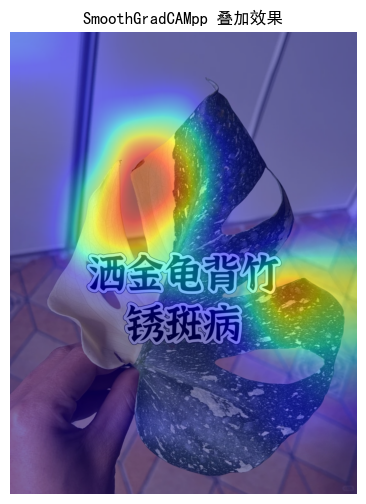


üîç ËØÜÂà´ÁªìÊûú: ÁôΩÁ≤âÁóÖ
üìù ÁóáÁä∂ÊèèËø∞: Âè∂Áâá„ÄÅÂ´©Ëåé„ÄÅËä±ËïæË°®Èù¢Ë¶ÜÁõñ‰∏ÄÂ±ÇÁôΩËâ≤Á≤âÊú´Áä∂ÈúâÂ±ÇÔºàËèå‰∏ùÂíåÂ≠¢Â≠êÔºâÔºåÂêéÊúüÁóÖÊñëÂèò‰∏∫ÁÅ∞Ëâ≤ÔºåÂè∂ÁâáÊâ≠Êõ≤„ÄÅËêéÁº©ÔºåÊ§çÊ†™ÁîüÈïøÂèóÈòª
üíä Êé®ËçêÈò≤Ê≤ªÊñπÊ°à:
1. Èõ®Â≠£ÊàñÈ´òÊ∏©È´òÊπøÂ≠£ËäÇÂâçÔºåÂñ∑ÊñΩÊ≥¢Â∞îÂ§öÊ∂≤Ôºà1:1:100ÔºâÊàñÁü≥Á°´ÂêàÂâÇÔºà0.3-0.5 Ê≥¢ÁæéÂ∫¶ÔºâÔºåÂΩ¢Êàê‰øùÊä§Â±èÈöú
2. Áî®ËΩØÂ∏ÉËò∏ÂèñÁ®ÄÈáäÁöÑÈÖíÁ≤æÔºà50%ÊµìÂ∫¶ÔºâÊàñÂ∞èËãèÊâìÊ∫∂Ê∂≤Ôºà5gÂ∞èËãèÊâì+1LÊ∞¥ÔºâËΩªËΩªÊì¶Êã≠ÁóÖÂè∂ÔºåÁ†¥ÂùèËèå‰∏ùÁªìÊûÑ
3. ÊàäÂîëÈÜáÔºà25%Ê∞¥‰π≥ÂâÇ2000ÂÄçÊ∂≤ÔºâÊàñÂê°ÂîëÈÜöËèåÈÖØÔºà25%ÊÇ¨ÊµÆÂâÇ1500ÂÄçÊ∂≤ÔºâÔºåÂÜÖÂê∏ÊÄßÂº∫ÔºåÂèØÊùÄÁÅ≠Ê∑±Â±ÇÁóÖËèå


In [20]:
visualize_random_images(learn)

In [21]:
#Ê§çÁâ©Êé®Ëçê
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import torch

In [22]:
#‰∏Ä„ÄÅÁî®Êà∑ÂÜ∑ÂêØÂä®  Êé®ËçêÁ≥ªÁªüÂÜ∑ÂêØÂä®Êï∞ÊçÆÂ§ÑÁêÜÔºàÂØπÂ∫î‰∏ªÁ®ãÂ∫èhybrid_recommendationÂáΩÊï∞Ôºâ
# ÂäüËÉΩÔºöÂä†ËΩΩÊ§çÁâ©ÁâπÂæÅÊï∞ÊçÆÔºåÁî®‰∫éÂü∫‰∫éÂÜÖÂÆπÁöÑÊé®Ëçê
# Step 1: ËØªÂèñÊ§çÁâ©Êï∞ÊçÆ
df = pd.read_csv(
    'u.item',
    sep='|',
    header=None,
    names=[
        'plant_id', 'plant','Â•ΩÂÖªÊä§','‰ª∑Ê†ºÂÆûÊÉ†','Ê¨æÂºèÂ§ö','ÁîüÈïøÈÄüÂ∫¶Âø´','ËÄêÊó±','ËÄêÂØí','ËÄêÈò¥','ËÄêÊ∞¥','ËÄêÂÖâËÄêÊôí','ÊòìÂºÄËä±','ÂÆπÊòìÂæíÈïøÊ≥õÊª•','ÈÄÇÂêàÊñ∞Êâã','ÊòìÁπÅÊÆñ','È£éÊ∞¥‰ª∑ÂÄº','ËßÇËµè‰ª∑ÂÄº','ÊØíÊÄßÊàêÂàÜ','ÂØìÊÑèÁæéÂ•Ω','ÊîπÂñÑÁ©∫Ê∞î','ÁºìËß£ÁÑ¶ËôëÊîπÂñÑÁù°Áú†','Áî®ÈÄîÂπøÊ≥õ','ÊäóÁóÖËô´ÂÆ≥','ÂúüÂ£§Ë¶ÅÊ±Ç‰∏•Ê†º','Á©∫Èó¥ÈúÄÊ±ÇÂ§ß','Èò≥ÂÖâË¶ÅÊ±ÇÈ´ò','Ê∞¥ÂàÜË¶ÅÊ±ÇÈ´ò','Ëä±Âè∂ÂºÇÂë≥'


    ],
    encoding='utf-8'
)

In [23]:
df.head()

plant_id   plant  Â•ΩÂÖªÊä§  ‰ª∑Ê†ºÂÆûÊÉ†  Ê¨æÂºèÂ§ö  ÁîüÈïøÈÄüÂ∫¶Âø´  ËÄêÊó±  ËÄêÂØí  ËÄêÈò¥  ËÄêÊ∞¥  ...  ÂØìÊÑèÁæéÂ•Ω  ÊîπÂñÑÁ©∫Ê∞î  \
0         1      Â§öËÇâ    1     1    1      1   1   1   1   0  ...     1     0   
1         2      ÁéâÊ†ë    1     1    1      1   1   0   1   1  ...     1     0   
2         3  Â©öÁ§ºÊ≤πÁîªÂêäÂÖ∞    1     1    1      1   1   1   1   0  ...     1     0   
3         4     ÈæüËÉåÁ´π    1     1    1      1   1   0   1   0  ...     1     0   
4         5     ËôéÁöÆÂÖ∞    1     1    1      1   1   1   1   1  ...     1     0   

   ÁºìËß£ÁÑ¶ËôëÊîπÂñÑÁù°Áú†  Áî®ÈÄîÂπøÊ≥õ  ÊäóÁóÖËô´ÂÆ≥  ÂúüÂ£§Ë¶ÅÊ±Ç‰∏•Ê†º  Á©∫Èó¥ÈúÄÊ±ÇÂ§ß  Èò≥ÂÖâË¶ÅÊ±ÇÈ´ò  Ê∞¥ÂàÜË¶ÅÊ±ÇÈ´ò  Ëä±Âè∂ÂºÇÂë≥  
0         0     0     1       0      0      0      0     0  
1         0     1     1       0      0      0      0     0  
2         0     0     1       0      0      0      0     0  
3         0     0     1       0      0      0      0     0  
4         0     1     1       0      0      0      0     0  

[5 rows x 28 columns]

In [24]:
# Step 2: Ê£ÄÊü•Êï∞ÊçÆÊòØÂê¶ÊúâÁº∫Â§±ÂÄº
df.isnull().sum()

plant_id    0
plant       0
Â•ΩÂÖªÊä§         0
‰ª∑Ê†ºÂÆûÊÉ†        0
Ê¨æÂºèÂ§ö         0
ÁîüÈïøÈÄüÂ∫¶Âø´       0
ËÄêÊó±          0
ËÄêÂØí          0
ËÄêÈò¥          0
ËÄêÊ∞¥          0
ËÄêÂÖâËÄêÊôí        0
ÊòìÂºÄËä±         0
ÂÆπÊòìÂæíÈïøÊ≥õÊª•      0
ÈÄÇÂêàÊñ∞Êâã        0
ÊòìÁπÅÊÆñ         0
È£éÊ∞¥‰ª∑ÂÄº        0
ËßÇËµè‰ª∑ÂÄº        0
ÊØíÊÄßÊàêÂàÜ        0
ÂØìÊÑèÁæéÂ•Ω        0
ÊîπÂñÑÁ©∫Ê∞î        0
ÁºìËß£ÁÑ¶ËôëÊîπÂñÑÁù°Áú†    0
Áî®ÈÄîÂπøÊ≥õ        0
ÊäóÁóÖËô´ÂÆ≥        0
ÂúüÂ£§Ë¶ÅÊ±Ç‰∏•Ê†º      0
Á©∫Èó¥ÈúÄÊ±ÇÂ§ß       0
Èò≥ÂÖâË¶ÅÊ±ÇÈ´ò       0
Ê∞¥ÂàÜË¶ÅÊ±ÇÈ´ò       0
Ëä±Âè∂ÂºÇÂë≥        0
dtype: int64

In [25]:
# Step 3: Âà†Èô§‰∏çÂøÖË¶ÅÁöÑÂàóÔºåÂè™‰øùÁïôÊ§çÁâ©IDÂíåÁ±ªÂà´‰ø°ÊÅØ
df_no_title = df.drop(columns=['plant'] 
                                         )

In [26]:
df_no_title.head()

plant_id  Â•ΩÂÖªÊä§  ‰ª∑Ê†ºÂÆûÊÉ†  Ê¨æÂºèÂ§ö  ÁîüÈïøÈÄüÂ∫¶Âø´  ËÄêÊó±  ËÄêÂØí  ËÄêÈò¥  ËÄêÊ∞¥  ËÄêÂÖâËÄêÊôí  ...  ÂØìÊÑèÁæéÂ•Ω  ÊîπÂñÑÁ©∫Ê∞î  \
0         1    1     1    1      1   1   1   1   0     1  ...     1     0   
1         2    1     1    1      1   1   0   1   1     1  ...     1     0   
2         3    1     1    1      1   1   1   1   0     1  ...     1     0   
3         4    1     1    1      1   1   0   1   0     1  ...     1     0   
4         5    1     1    1      1   1   1   1   1     1  ...     1     0   

   ÁºìËß£ÁÑ¶ËôëÊîπÂñÑÁù°Áú†  Áî®ÈÄîÂπøÊ≥õ  ÊäóÁóÖËô´ÂÆ≥  ÂúüÂ£§Ë¶ÅÊ±Ç‰∏•Ê†º  Á©∫Èó¥ÈúÄÊ±ÇÂ§ß  Èò≥ÂÖâË¶ÅÊ±ÇÈ´ò  Ê∞¥ÂàÜË¶ÅÊ±ÇÈ´ò  Ëä±Âè∂ÂºÇÂë≥  
0         0     0     1       0      0      0      0     0  
1         0     1     1       0      0      0      0     0  
2         0     0     1       0      0      0      0     0  
3         0     0     1       0      0      0      0     0  
4         0     1     1       0      0      0      0     0  

[5 rows x 27 columns]

In [27]:
# Step 4: ËÆ°ÁÆóÊ§çÁâ©‰πãÈó¥ÁöÑ‰ΩôÂº¶Áõ∏‰ººÂ∫¶ÔºåÁîüÊàê‰∏Ä‰∏™Áõ∏‰ººÂ∫¶Áü©Èòµ
item_similarity = cosine_similarity(df_no_title.drop(columns=['plant_id']))

In [28]:
item_similarity

array([[1.        , 0.8       , 0.93094934, ..., 0.86666667, 0.88852332,
        0.74535599],
       [0.8       , 1.        , 0.85933785, ..., 0.8       , 0.82928843,
        0.74535599],
       [0.93094934, 0.85933785, 1.        , ..., 0.85933785, 0.82717019,
        0.72057669],
       ...,
       [0.86666667, 0.8       , 0.85933785, ..., 1.        , 0.88852332,
        0.89442719],
       [0.88852332, 0.82928843, 0.82717019, ..., 0.88852332, 1.        ,
        0.79471941],
       [0.74535599, 0.74535599, 0.72057669, ..., 0.89442719, 0.79471941,
        1.        ]])

In [29]:
# Step 5: ÊµãËØï1ÔºöÊâæÂà∞ 'Â§öËÇâ' ÁöÑ plant_id
favorite_plant_id = df[df['plant']=='Â§öËÇâ']['plant_id'].values[0]

In [30]:
#ËæìÂá∫ÊµãËØïÁªìÊûú
favorite_plant_id

1

In [31]:
# Step 6: ÊµãËØï2ÔºöÊâæÂà∞ÊúÄÁõ∏‰ººÁöÑÁªøÊ§çÔºåÊåâÁõ∏‰ººÂ∫¶‰ªéÈ´òÂà∞‰ΩéÊéíÂ∫è
most_similar_plant = item_similarity[favorite_plant_id - 1].argsort()[::-1]

In [32]:
most_similar_plant

array([ 0,  5,  7, 58,  6, 59,  2, 31, 30, 47, 36, 37, 35, 11, 21, 17, 55,
       57, 70, 77, 64, 32,  3, 82, 10, 68, 69, 51, 81, 29,  4, 20, 72,  8,
       18, 67, 65, 73, 24, 25, 27, 63, 66, 46, 26, 39, 56, 43,  9, 19, 28,
       16, 41, 40, 42, 33, 14, 80, 62, 12, 13, 15, 75, 52,  1, 60, 38, 45,
       53, 54, 22, 23, 44, 50, 76, 74, 83, 48, 34, 78, 79, 49, 61, 71],
      dtype=int64)

In [33]:
# Step 7:ÊµãËØï3Ôºö Ëé∑Âèñ‰∏é 'Â§öËÇâ' ÊúÄÁõ∏‰ººÁöÑÂâç5ÁßçÁªøÊ§ç
similar_plant_titles = df.loc[most_similar_plant[1:6]]['plant']

In [34]:
# Step 8: ËæìÂá∫Êé®ËçêÁªìÊûú
print(similar_plant_titles)

5      ‰ªô‰∫∫ÁêÉ
7     ËêΩÂú∞ÁîüÊ†π
58     ÂêõÂ≠êÂÖ∞
6      Â§™Èò≥Ëä±
59     ÁΩóÊ±âÊùæ
Name: plant, dtype: object


In [35]:
from pathlib import Path
import numpy as np
import pandas as pd
from surprise import Dataset, Reader, SVD, accuracy

In [36]:
def build_trainset(df):
    """Êää DataFrame Â∞ÅÊàê Surprise ÁöÑ trainset„ÄÇ"""
    return Dataset.load_from_df(df[['user_id', 'plant_id', 'rating']], reader) \
                  .build_full_trainset()

In [37]:
def top_n(algo, user_id, n=5, items_df=None):
    # Ëé∑ÂèñÊâÄÊúâÊ§çÁâ©IDÁöÑÈ¢ÑÊµã
    predictions = [algo.predict(user_id, item_id) for item_id in items_df['plant_id']]
    
    # ËΩ¨Êç¢‰∏∫DataFrameÊ†ºÂºè
    results = pd.DataFrame([(pred.iid, 
                            items_df.loc[items_df.plant_id==pred.iid, 'title'].iloc[0], 
                            round(pred.est, 4)) 
                          for pred in predictions],
                         columns=['plant_id', 'Ê§çÁâ©ÂêçÁß∞', 'È¢ÑÊµãËØÑÂàÜ'])
    
    return results.sort_values('È¢ÑÊµãËØÑÂàÜ', ascending=False).head(n)

In [38]:
def add_and_retrain(algo, ratings_df, new_ratings_df):
    updated = pd.concat([ratings_df, new_ratings_df], ignore_index=True)
    new_trainset = build_trainset(updated)
    algo.fit(new_trainset)
    return algo, updated

In [39]:
# ---------------- 0. ÂÖ®Â±ÄËÆæÁΩÆ ----------------
SEED = 42
np.random.seed(SEED)
DATA_DIR = Path('models')      # Ê†πÊçÆÈúÄË¶Å‰øÆÊîπ

In [40]:
# ---------------- 1. Âä†ËΩΩÊï∞ÊçÆ ----------------
ratings_cols = ['user_id', 'plant_id', 'rating', 'timestamp']
ratings = pd.read_csv(
    DATA_DIR / 'u.data',
    sep='\t',
    names=ratings_cols,
    dtype={'user_id': 'int32', 'plant_id': 'int32',
           'rating': 'int8', 'timestamp': 'int32'}
)


In [41]:
ratings.head()

user_id  plant_id  rating   timestamp
0       55        45       3  1002259248
1      121        30       2  1004377117
2        7        33       2  1005089177
3      139        73       2  1005647938
4       67        55       2  1006414676

In [42]:
plant_cols = ['plant_id', 'title']  
plant = pd.read_csv(
    DATA_DIR / 'u.item',
    sep='|',
    names=plant_cols,
    usecols=[0, 1],          # Âè™‰øùÁïôÂøÖÈúÄÂàó
    encoding='utf-8',
    dtype={'plant_id': 'int32', 'title': 'string'}
)



In [43]:
# ---------------- 2. Surprise Êï∞ÊçÆÈõÜÂ∞ÅË£Ö ----------------
reader = Reader(rating_scale=(
    ratings.rating.min(),
    ratings.rating.max()
))

In [44]:
# 80/20 ÊåâÊó∂Èó¥Â∫èÂàóÂàáÂàÜ
ratings_sorted = ratings.sort_values('timestamp')

In [45]:
split_idx = int(0.8 * len(ratings_sorted))
train_df, test_df = ratings_sorted[:split_idx],ratings_sorted[split_idx:]

In [46]:
trainset = build_trainset(train_df)
testset = list(test_df[['user_id',
                        'plant_id',
                        'rating']].itertuples(
                            index=False,
                            name=None
                        ))

In [47]:
# ---------------- 3. ËÆ≠ÁªÉ SVD ----------------
algo = SVD(random_state=SEED,
           n_factors=100,
           n_epochs=25)
algo.fit(trainset)

In [48]:
# ---------------- 4. ËØÑ‰º∞ ----------------
# Âú®Ê®°ÂûãËÆ≠ÁªÉÂêéÊ∑ªÂä†ËØÑ‰º∞‰ª£Á†Å
from surprise import accuracy
import matplotlib.pyplot as plt

# Âú®ÊµãËØïÈõÜ‰∏äËØÑ‰º∞
preds = algo.test(testset)
print(f'RMSE: {accuracy.rmse(preds, verbose=False):.4f}')
print(f'MAE : {accuracy.mae(preds,  verbose=False):.4f}')

RMSE: 1.5715
MAE : 1.2974


In [49]:
# ---------------- 5. Êñ∞Áî®Êà∑ÂÜ∑ÂêØÂä® + ÈáçËÆ≠ ----------------
new_uid = ratings.user_id.max() + 1
# ÂÆâÂÖ®Êü•ËØ¢ÊñπÂºè
def get_plant_id(df, plant_name):
    results = df[df.title.str.contains(plant_name, case=False, na=False)]
    if not results.empty:
        return int(results.iloc[0].plant_id)
    raise ValueError(f"Êú™ÊâæÂà∞ÂåÖÂê´'{plant_name}'ÁöÑÊ§çÁâ©")

try:
    new_user_ratings = pd.DataFrame({
        'user_id': [new_uid, new_uid],
        'plant_id': [
            get_plant_id(plant, 'ÁéâÊ†ë'),
            get_plant_id(plant, 'Â§™Èò≥Ëä±')  
        ],
        'rating': [1,5],
        'timestamp': [ratings.timestamp.max() + 1] * 2
    })
except ValueError as e:
    print(f"ÈîôËØØ: {e}")
    print("ÂèØÁî®Ê§çÁâ©ÂàóË°®:", planet.title.unique().tolist())


In [50]:
algo, ratings = add_and_retrain(algo, ratings, new_user_ratings)
print(f"\n‰∏∫Êñ∞Áî®Êà∑ {new_uid} Êé®ËçêÔºö")
print(top_n(algo, user_id=new_uid, items_df=plant))  


‰∏∫Êñ∞Áî®Êà∑ 151 Êé®ËçêÔºö
    plant_id Ê§çÁâ©ÂêçÁß∞    È¢ÑÊµãËØÑÂàÜ
6          7  Â§™Èò≥Ëä±  3.8631
61        62   ÊñáÁ´π  3.3580
60        61  Êï£Â∞æËëµ  3.3081
17        18  Êú±È°∂Á∫¢  3.3078
56        57  Êª°Â§©Êòü  3.2415


RMSE: 0.9302
MAE:  0.7609

Ê®°ÂûãËØÑ‰º∞ÁªìÊûúÔºö
RMSE: 0.9302
MAE: 0.7609


<module 'matplotlib.pyplot' from 'd:\\CBY\\CBYANACONDA\\envs\\datascience\\Lib\\site-packages\\matplotlib\\pyplot.py'>

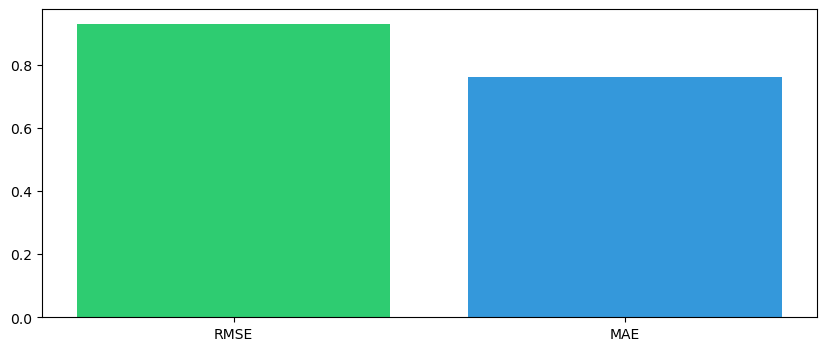

In [51]:
# Êï¥‰ΩìËØÑ‰º∞Êä•ÂëäÂèäÂèØËßÜÂåñ
from surprise import accuracy
import matplotlib.pyplot as plt

# Âú®ÊµãËØïÈõÜ‰∏äËØÑ‰º∞
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

# ËÆ°ÁÆóËØÑ‰º∞ÊåáÊ†á
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

# ÊâìÂç∞Ê†ºÂºèÂåñÁöÑËØÑ‰º∞ÁªìÊûú
print(f"\nÊ®°ÂûãËØÑ‰º∞ÁªìÊûúÔºö")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")


# ÂèØÈÄâÁöÑÂèØËßÜÂåñ‰ª£Á†Å
plt.figure(figsize=(10,4))
plt.bar(['RMSE', 'MAE'], [rmse, mae], color=['#2ecc71', '#3498db'])
plt

In [52]:
#‰∫å„ÄÅÂçèÂêåËøáÊª§  #ÂÆûÁé∞Ê§çÁâ©Êé®ËçêÁ≥ªÁªüÁöÑÂçèÂêåËøáÊª§ÈÉ®ÂàÜÔºåÂåÖÂê´Êï∞ÊçÆÂä†ËΩΩ„ÄÅÊ®°ÂûãËÆ≠ÁªÉ„ÄÅÂµåÂÖ•‰øùÂ≠òÂÖ®ÊµÅÁ®ã
from fastai.tabular.all import *
from fastai.collab import *
from fastai.metrics import rmse, mae
from fastai.callback.tracker import EarlyStoppingCallback, SaveModelCallback
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
from pathlib import Path
import torch
import torch.nn.functional as F
from torch.optim import Adam
import os

In [53]:
def collab_pipeline():
    # Êï∞ÊçÆÂä†ËΩΩ
    plants = pd.read_csv('u.item', sep='|', 
                       names=['plant_id', 'plant', 'Â•ΩÂÖªÊä§', '‰ª∑Ê†ºÂÆûÊÉ†', 'Ê¨æÂºèÂ§ö'])
    ratings = pd.read_csv('u.data', sep='\t',
                        names=['user_id','plant_id','rating','timestamp'])
    
    # ÂàõÂª∫Êï∞ÊçÆÂä†ËΩΩÂô®
    dls = CollabDataLoaders.from_df(ratings, user_name='user_id', item_name='plant_id', 
                                  rating_name='rating', valid_pct=0.2, bs=64)
    
    # Ê®°ÂûãÈÖçÁΩÆ
    learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5), 
                         metrics=[rmse, mae], wd=0.1)
    
    # ËÆ≠ÁªÉÊµÅÁ®ãÔºàÂ∏¶ÂõûË∞ÉÈ™åËØÅÔºâ
    learn.fit_one_cycle(5, 5e-3, 
                      cbs=[SaveModelCallback(monitor='valid_loss'), 
                          EarlyStoppingCallback(monitor='valid_loss')])
    
    # ‰øùÂ≠òËµÑ‰∫ß
    return {
        'model': learn,
        'embeddings': {
            'user': learn.model.u_weight.weight.data.cpu(),
            'item': learn.model.i_weight.weight.data.cpu()
        }
    }


In [55]:
# ÂçèÂêåËøáÊª§Ê®°ÂûãËÆ≠ÁªÉ‰ª£Á†ÅÂùó
from fastai.collab import collab_learner

# ÂàõÂª∫Êï∞ÊçÆÂä†ËΩΩÂô®ÔºàÁ°Æ‰øùÂ∑≤Â≠òÂú®Ôºâ
dls = CollabDataLoaders.from_df(
    ratings,
    user_name='user_id',
    item_name='plant_id',
    rating_name='rating',
    valid_pct=0.2,
    bs=64
)

# ÂàõÂª∫Â≠¶‰π†Âô®
learn = collab_learner(
    dls,
    n_factors=50,
    y_range=(0, 5.5),
    metrics=[rmse, mae]
)

# ËÆ≠ÁªÉÊ®°Âûã
learn.fit_one_cycle(5, 5e-3)

# ‰øÆÊ≠£EmbeddingDotBiasÊ®°ÂûãÁöÑÂèÇÊï∞‰øùÂ≠òÊñπÂºè
# ‰øÆÊ≠£ÂçèËÆÆÁâàÊú¨ÊåáÂÆöÊñπÂºè
import torch

with open('Ê§çÁâ©Êé®ËçêÁ≥ªÁªü.pkl', 'wb') as f:
    torch.save({
        'user_emb': learn.model.u_weight.weight.data,
        'item_emb': learn.model.i_weight.weight.data,
        'user_ids': dls.classes['user_id'],
        'plant_ids': dls.classes['plant_id']
    }, f, pickle_protocol=4)  # ‰ΩøÁî®Ê≠£Á°ÆÁöÑÂèÇÊï∞ÂêçÁß∞